# 1.0 Library Load

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import scipy.stats as stats

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
  LabelEncoder,
  MinMaxScaler,
  OneHotEncoder,
  OrdinalEncoder,
  StandardScaler
)

import pickle

# Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

We will use Random Forest Classifier, Logistic Regression, Gradient Boost Classifier, KNN Classifier

# 2.0 Data Understanding

* `Trip_ID`: ID for TRIP

* `Trip_Distance`: The distance for the trip requested by the customer

* `Type_of_Cab`: Category of the cab requested by the customer

* `Customer_Since_Months`: Customer using cab services since n months; 0 month means current month

* `Life_Style_Index`: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour

* `Confidence_Life_Style_Index`: Category showing confidence on the index mentioned above

* `Destination_Type`: Sigma Cabs divides any destination in one of the 14 categories.

* `Customer_Rating`: Average of life time ratings of the customer till date

* `Cancellation_Last_1Month`: Number of trips cancelled by the customer in last 1 month

* `Var1, Var2 and Var3`: Continuous variables masked by the company. Can be used for modelling purposes

* `Gender`: Gender of the customer

* `Surge_Pricing_Type`: Target (can be of 3 types)

# 3.0 Load Data

In [2]:
path = '/content/drive/MyDrive/Dibimbing/Take Home Test - Data Science/Dataset/sigma_cabs.csv'

In [3]:
df = pd.read_csv(path)

# 4.0 Data Pre-Processing

In [4]:
df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

## 4.1 Null Values Handling

There are `Null` values in several columns, therefore we will fill the `Numerical columns` with **Median** and the `Categorical columns` with the **Mode**

In [6]:
df.isnull().sum().sort_values(ascending = False)

,0
Var1,71030
Type_of_Cab,20210
Confidence_Life_Style_Index,20193
Life_Style_Index,20193
Customer_Since_Months,5920
Trip_Distance,0
Trip_ID,0
Destination_Type,0
Customer_Rating,0
Cancellation_Last_1Month,0


In [7]:
df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [8]:
# For numerical columns, fill with median
num_cols = ['Customer_Since_Months','Life_Style_Index','Var1']
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with mode
cat_cols = ['Type_of_Cab','Confidence_Life_Style_Index']
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-2603517479.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-2603517479.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [9]:
df.isnull().sum()

,0
Trip_ID,0
Trip_Distance,0
Type_of_Cab,0
Customer_Since_Months,0
Life_Style_Index,0
Confidence_Life_Style_Index,0
Destination_Type,0
Customer_Rating,0
Cancellation_Last_1Month,0
Var1,0


No more `Null` values detected from all columns!

## 4.2 Duplicates Handling

In [10]:
len(df.drop_duplicates())/len(df)

1.0

No Duplicates detected!

## 4.3 Outlier Handling

In [11]:
df_numericals = df.select_dtypes(include='number')

In [12]:
def check_plot(df, variable):
    plt.figure(figsize=(12, 4))
    print(f'{variable}')


    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title('Probabilty Plot / Q-Q Plot')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()
    plt.tight_layout()

Trip_Distance


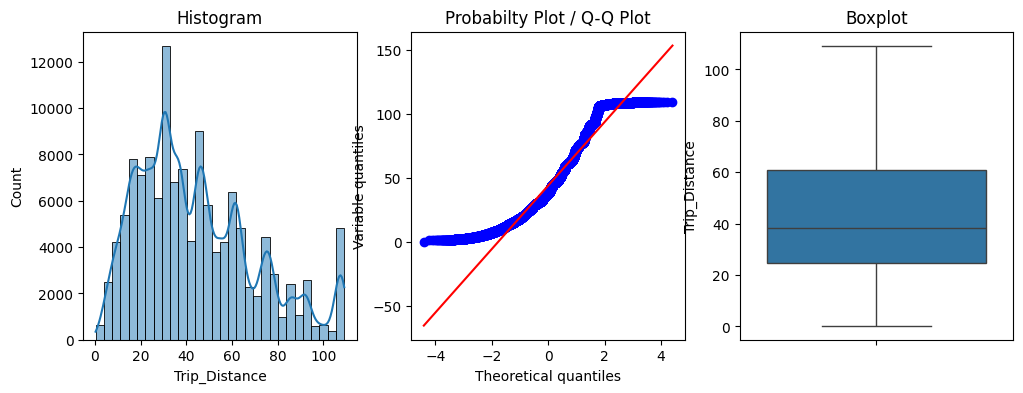

Customer_Since_Months


<Figure size 640x480 with 0 Axes>

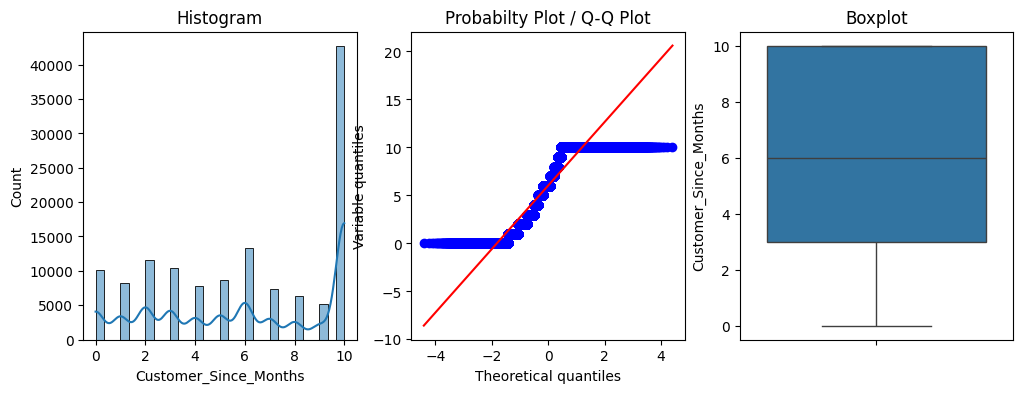

Life_Style_Index


<Figure size 640x480 with 0 Axes>

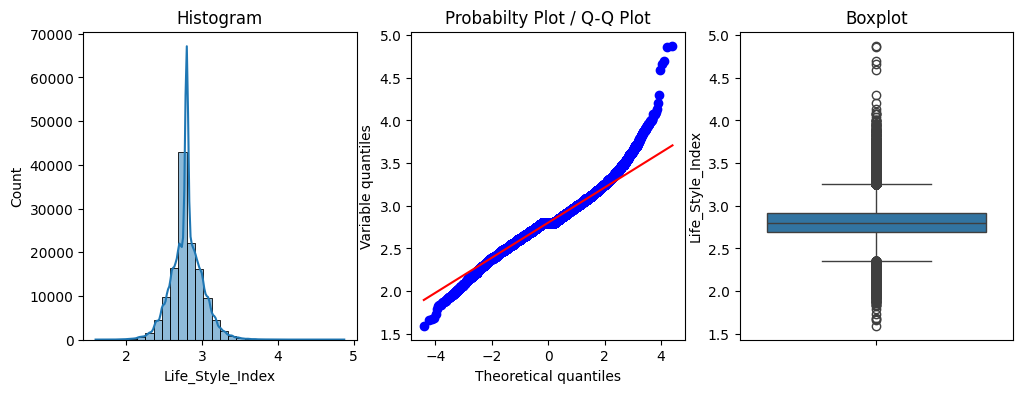

Customer_Rating


<Figure size 640x480 with 0 Axes>

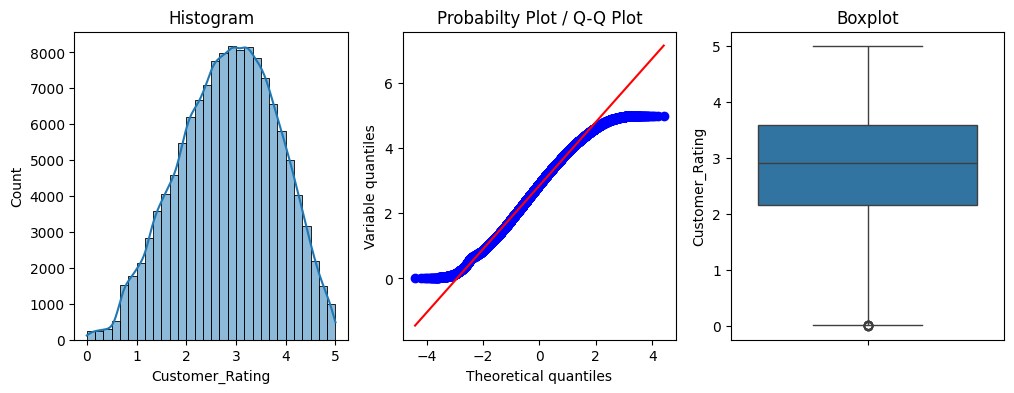

Cancellation_Last_1Month


<Figure size 640x480 with 0 Axes>

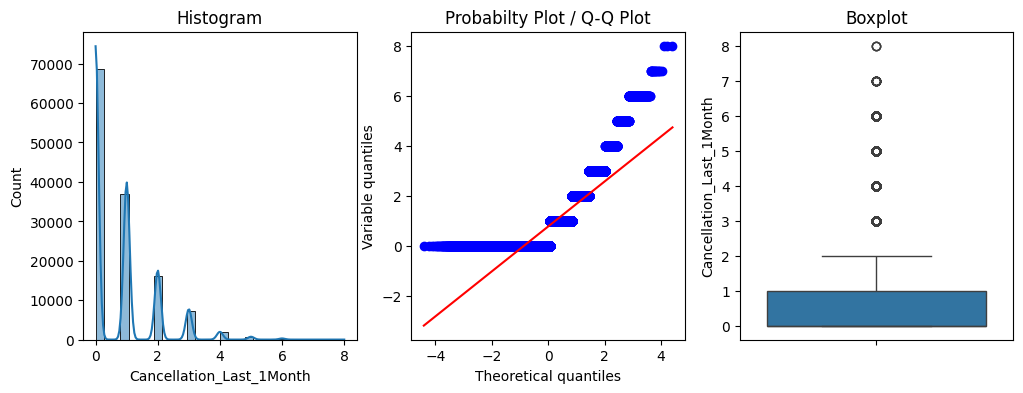

Var1


<Figure size 640x480 with 0 Axes>

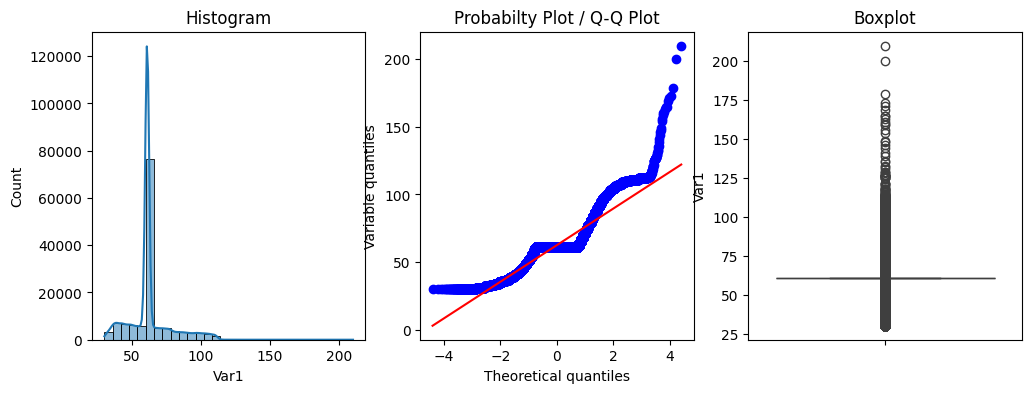

Var2


<Figure size 640x480 with 0 Axes>

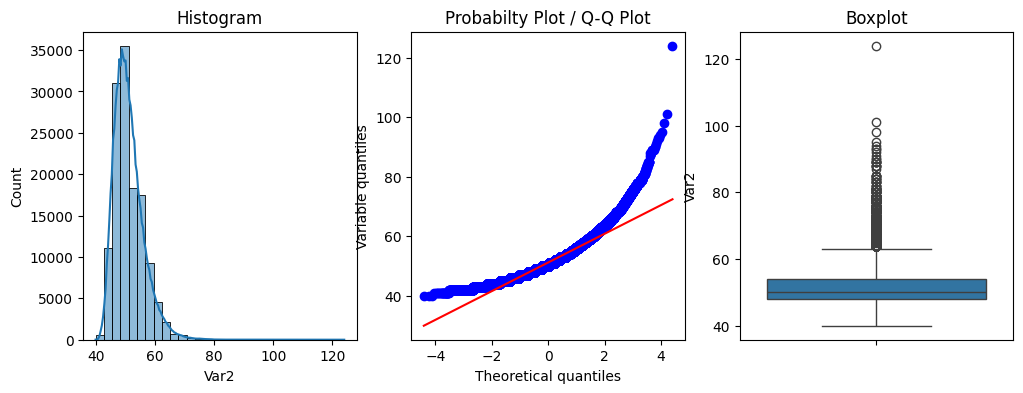

Var3


<Figure size 640x480 with 0 Axes>

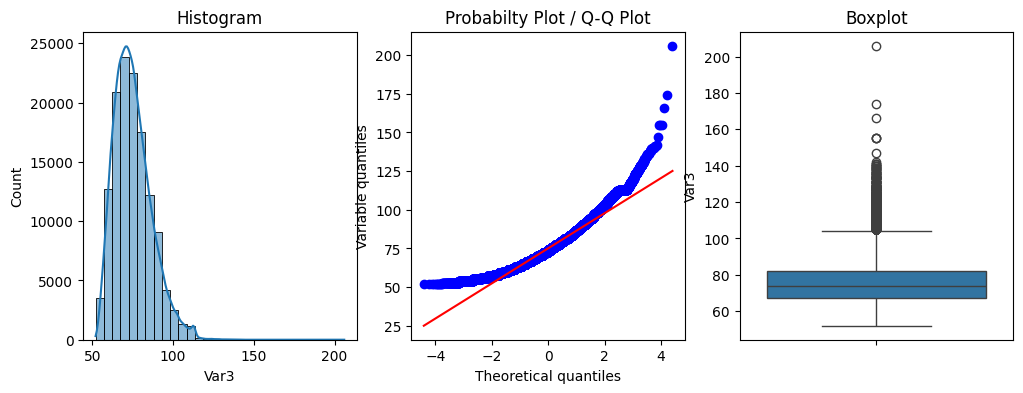

Surge_Pricing_Type


<Figure size 640x480 with 0 Axes>

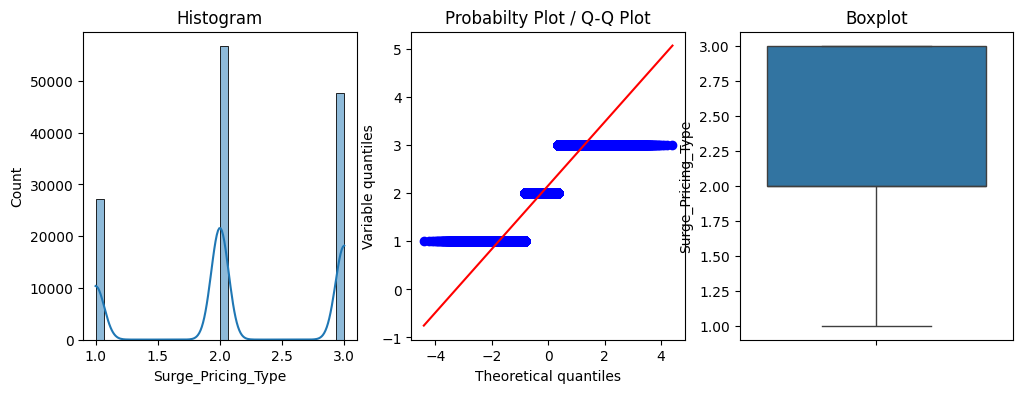

<Figure size 640x480 with 0 Axes>

In [13]:
for col in df_numericals:
  check_plot(df,col)

There are some outliers within the data, but it will not be removed and will be used in the model training

## 4.4 Convert Datatypes

In [14]:
df['Customer_Since_Months'] = df['Customer_Since_Months'].astype(int)

In [15]:
df['Var1'] = df['Var1'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  131662 non-null  object 
 3   Customer_Since_Months        131662 non-null  int64  
 4   Life_Style_Index             131662 non-null  float64
 5   Confidence_Life_Style_Index  131662 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         131662 non-null  int64  
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

# 5.0 EDA

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  131662 non-null  object 
 3   Customer_Since_Months        131662 non-null  int64  
 4   Life_Style_Index             131662 non-null  float64
 5   Confidence_Life_Style_Index  131662 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         131662 non-null  int64  
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [18]:
df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1,2.42769,A,A,3.90500,0,40,46,60,Female,2
1,T0005689461,29.47,B,10,2.78245,B,A,3.45000,0,38,56,78,Male,2
2,T0005689464,41.58,B,10,2.79805,B,E,3.50125,2,61,56,77,Male,2
3,T0005689465,61.56,C,10,2.79805,B,A,3.45375,0,61,52,74,Male,3
4,T0005689467,54.95,C,10,3.03453,B,A,3.40250,4,51,49,102,Male,2


<Axes: xlabel='Destination_Type', ylabel='count'>

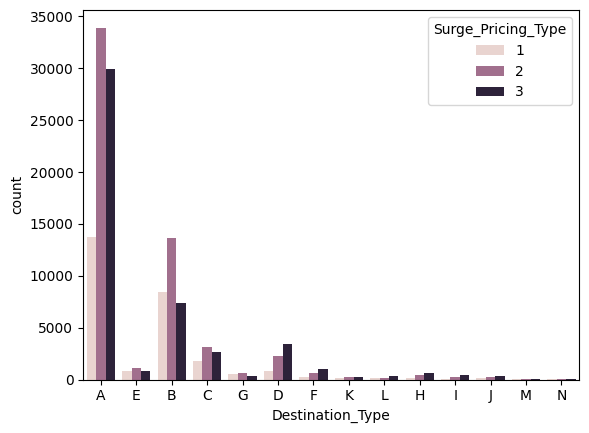

In [19]:
sns.countplot(data=df,
            x='Destination_Type',
            hue='Surge_Pricing_Type'
            )

In [20]:
df.to_csv(
    'cleaned_data.csv', index = False
)

# 6.0 Split Dataset

In [21]:
# Split train test
X = df.drop(columns='Surge_Pricing_Type')
y = df[['Surge_Pricing_Type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 6.1 Data Transformation

### 6.1a Drop Useless Column

In [22]:
X_train = X_train.drop(columns=['Trip_ID'])

In [23]:
X_test = X_test.drop(columns=['Trip_ID'])

### 6.1b Encode Variables

In [24]:
# Encode 'Gender' column with LabelEncoder
gender_encoder = LabelEncoder()

X_train['Gender'] = gender_encoder.fit_transform(X_train[['Gender']])
X_test['Gender'] = gender_encoder.transform(X_test[['Gender']])

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [25]:
# Encode 'Confidence_Life_Style_Index' column with LabelEncoder
Confidence_Life_Style_Index_encoder = LabelEncoder()

X_train['Confidence_Life_Style_Index'] = Confidence_Life_Style_Index_encoder.fit_transform(X_train[['Confidence_Life_Style_Index']])
X_test['Confidence_Life_Style_Index'] = Confidence_Life_Style_Index_encoder.transform(X_test[['Confidence_Life_Style_Index']])

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [26]:
# Encode 'Destination_Type' column with LabelEncoder
Destination_Type_encoder = LabelEncoder()

X_train['Destination_Type'] = Destination_Type_encoder.fit_transform(X_train[['Destination_Type']])
X_test['Destination_Type'] = Destination_Type_encoder.transform(X_test[['Destination_Type']])

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [27]:
# Encode 'Type_of_Cab' column with LabelEncoder
Type_of_Cab_encoder = LabelEncoder()

X_train['Type_of_Cab'] = Type_of_Cab_encoder.fit_transform(X_train[['Type_of_Cab']])
X_test['Type_of_Cab'] = Type_of_Cab_encoder.transform(X_test[['Type_of_Cab']])

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### 6.1c Scale Numeric Variables

In [29]:
# Scale 'Trip_Distance' column for better machine reading using MinMaxScaler
scaler = MinMaxScaler()
X_train['Trip_Distance'] = scaler.fit_transform(X_train[['Trip_Distance']])
X_test['Trip_Distance'] = scaler.transform(X_test[['Trip_Distance']])

scaler.inverse_transform([[1]])

array([[109.23]])

In [30]:
# Scale 'Var1' column for better machine reading using MinMaxScaler
scaler = MinMaxScaler()
X_train['Var1'] = scaler.fit_transform(X_train[['Var1']])
X_test['Var1'] = scaler.transform(X_test[['Var1']])

scaler.inverse_transform([[1]])

array([[171.]])

In [31]:
# Scale 'Var2' column for better machine reading using MinMaxScaler
scaler = MinMaxScaler()
X_train['Var2'] = scaler.fit_transform(X_train[['Var2']])
X_test['Var2'] = scaler.transform(X_test[['Var2']])

scaler.inverse_transform([[1]])

array([[101.]])

In [32]:
# Scale 'Var3' column for better machine reading using MinMaxScaler
scaler = MinMaxScaler()
X_train['Var3'] = scaler.fit_transform(X_train[['Var3']])
X_test['Var3'] = scaler.transform(X_test[['Var3']])

scaler.inverse_transform([[1]])

array([[206.]])

### 6.1d Heatmap Correlation

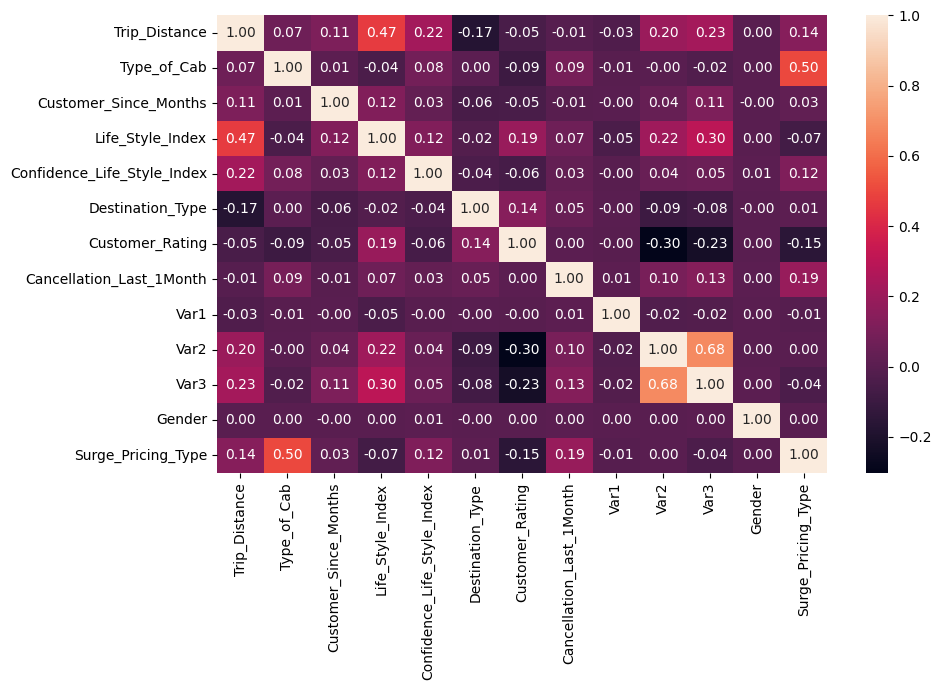

In [33]:
# Create Heatmap Correlation
flightprice_train = pd.concat([X_train, y_train], axis=1)
corr = flightprice_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.tight_layout()
plt.show()

# 7.0 Model Training

## 7.1 Train

### 7.1.1 Logistic Regression

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
y_pred = logreg.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.50      0.60     21809
           2       0.60      0.74      0.66     45343
           3       0.66      0.60      0.63     38177

    accuracy                           0.64    105329
   macro avg       0.66      0.61      0.63    105329
weighted avg       0.65      0.64      0.64    105329



### 7.1.2 Random Forest Classifier

#### Not Tuned

In [36]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=200, random_state=42)

In [37]:
y_pred = rf_clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     21809
           2       1.00      1.00      1.00     45343
           3       1.00      1.00      1.00     38177

    accuracy                           1.00    105329
   macro avg       1.00      1.00      1.00    105329
weighted avg       1.00      1.00      1.00    105329



#### Tuned

In [40]:
param_grid = {
    'n_estimators': [100, 300, 600],
    'min_samples_leaf': [5,10],
    'min_samples_split': [5,10],
    'max_features': ["log2"],
    'bootstrap': [True],
    'oob_score': [True],
    'random_state': [42],
    'n_jobs': [-1]
}


grid_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_features': ['log2'],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 300, 600],
                                        'n_jobs': [-1], 'oob_score': [True],
                                        'random_state': [42]},
                   scoring='accuracy')

In [41]:
# Get the best model
rf_clf_best_model = grid_rf.best_estimator_

In [42]:
y_pred_rf_clf_best_model = rf_clf_best_model.predict(X_train)
print(classification_report(y_train, y_pred_rf_clf_best_model))

              precision    recall  f1-score   support

           1       0.80      0.55      0.65     21809
           2       0.68      0.88      0.77     45343
           3       0.82      0.67      0.74     38177

    accuracy                           0.74    105329
   macro avg       0.76      0.70      0.72    105329
weighted avg       0.75      0.74      0.73    105329



### 7.1.3 Gradient Boost Classifier

#### Not Tuned

In [40]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(n_estimators=200, random_state=42)

In [41]:
y_pred = gb_clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.54      0.63     21809
           2       0.64      0.84      0.73     45343
           3       0.75      0.61      0.68     38177

    accuracy                           0.69    105329
   macro avg       0.72      0.66      0.68    105329
weighted avg       0.71      0.69      0.69    105329



#### Tuned

In [42]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01]
}


grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [43]:
# Get the best model
gb_clf_best_model = grid.best_estimator_

In [44]:
y_pred = gb_clf_best_model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.54      0.64     21809
           2       0.65      0.84      0.73     45343
           3       0.76      0.62      0.68     38177

    accuracy                           0.70    105329
   macro avg       0.73      0.67      0.68    105329
weighted avg       0.71      0.70      0.69    105329



### 7.1.4 KNN

#### Not Tuned

In [45]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [46]:
y_pred = knn.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.69      0.67      0.68     21809
           2       0.71      0.80      0.75     45343
           3       0.79      0.68      0.73     38177

    accuracy                           0.73    105329
   macro avg       0.73      0.72      0.72    105329
weighted avg       0.73      0.73      0.73    105329



#### Tuned

In [47]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

In [48]:
param_grid = {
    'knn__n_neighbors': range(3, 31, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

In [72]:
grid_rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rand.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'knn__n_neighbors': range(3, 31, 2),
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='accuracy')

In [74]:
print("Best params:", grid_rand.best_params_)
print("Best CV Score:", grid_rand.best_score_)

Best params: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 25}
Best CV Score: 0.6751132012420629


In [75]:
# Get the best model
knn_best_model = grid_rand.best_estimator_

## 7.2 Test

### 7.2.1 Logistic Regression

In [80]:
y_test_pred = logreg.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.72      0.51      0.60      5405
           2       0.60      0.74      0.66     11385
           3       0.66      0.59      0.63      9543

    accuracy                           0.64     26333
   macro avg       0.66      0.61      0.63     26333
weighted avg       0.65      0.64      0.64     26333



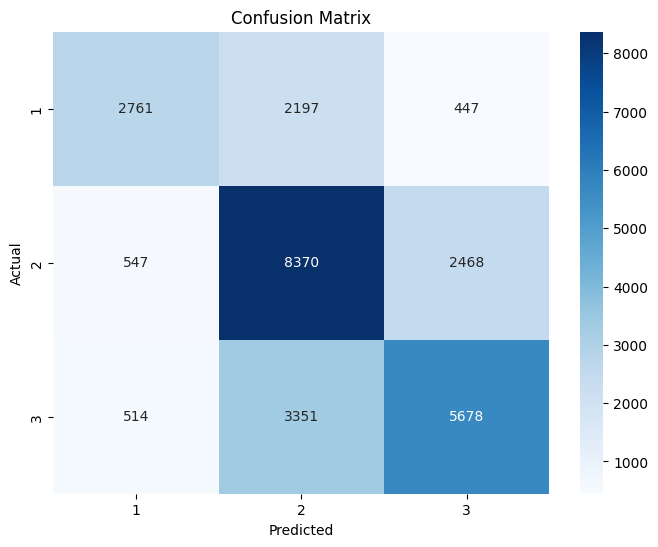

In [81]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

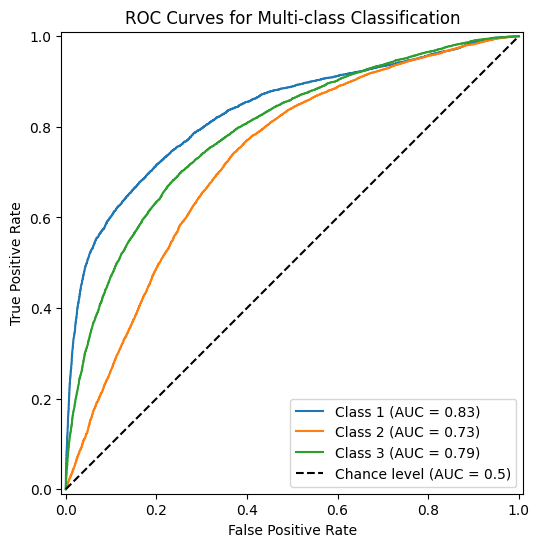

In [85]:
# For each class, create a one-vs-rest ROC curve
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(logreg.classes_):
    y_score = logreg.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

### 7.2.2 Random Forest Classifier

#### Not Tuned

In [60]:
y_test_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.76      0.53      0.63      5405
           2       0.64      0.82      0.72     11385
           3       0.73      0.61      0.67      9543

    accuracy                           0.69     26333
   macro avg       0.71      0.66      0.67     26333
weighted avg       0.70      0.69      0.68     26333



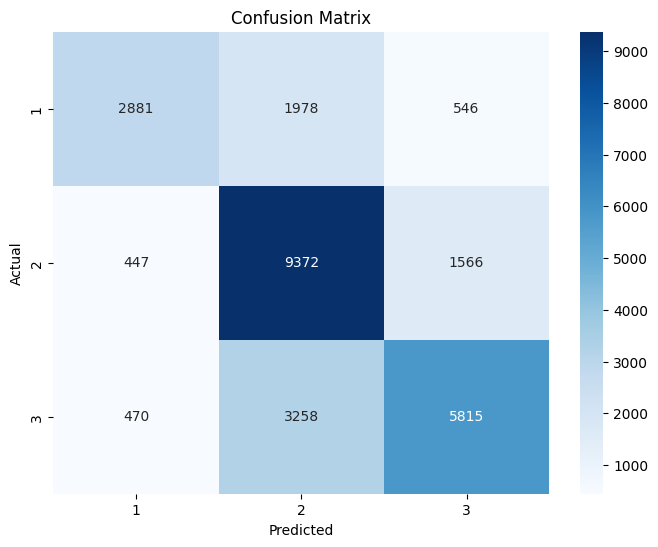

In [61]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

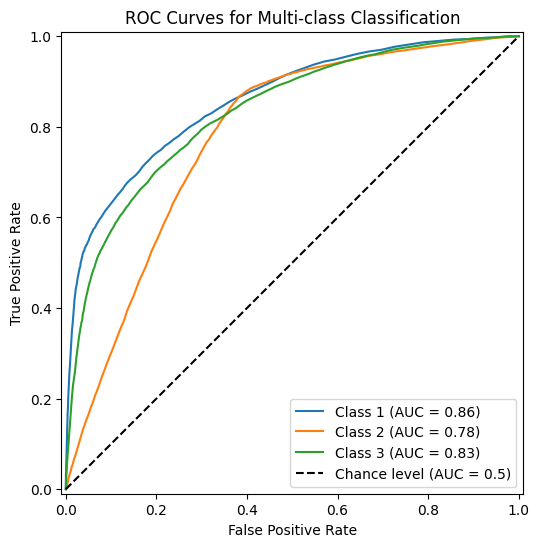

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(rf_clf.classes_):
    y_score = rf_clf.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

#### Tuned

In [43]:
y_pred_rf_clf_best_model = rf_clf_best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf_clf_best_model))

              precision    recall  f1-score   support

           1       0.77      0.53      0.63      5405
           2       0.64      0.85      0.73     11385
           3       0.75      0.59      0.66      9543

    accuracy                           0.69     26333
   macro avg       0.72      0.66      0.67     26333
weighted avg       0.71      0.69      0.68     26333



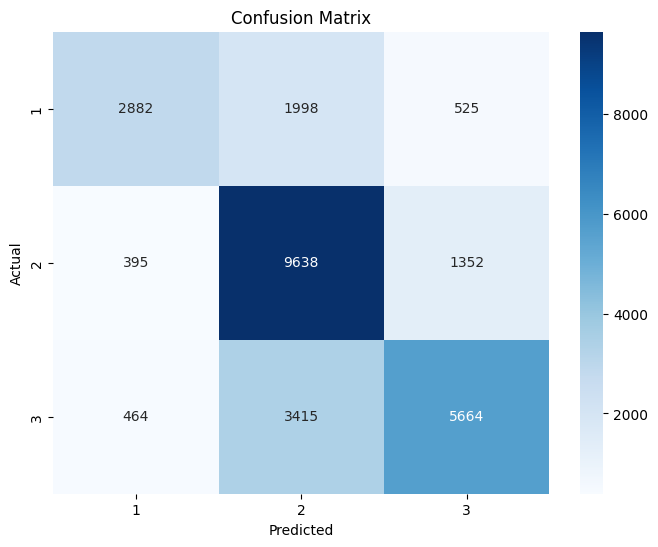

In [47]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf_clf_best_model)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

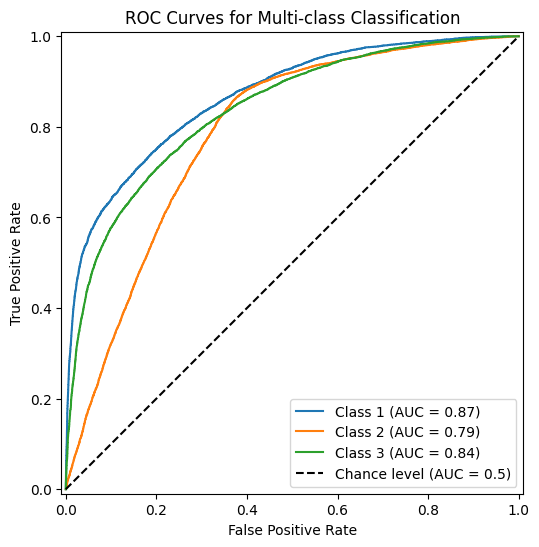

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(rf_clf_best_model.classes_):
    y_score = rf_clf_best_model.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

### 7.2.3 Gradient Boost Classifier

#### Not Tuned

In [64]:
y_test_pred = gb_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.77      0.54      0.63      5405
           2       0.64      0.83      0.73     11385
           3       0.74      0.61      0.67      9543

    accuracy                           0.69     26333
   macro avg       0.72      0.66      0.68     26333
weighted avg       0.71      0.69      0.69     26333



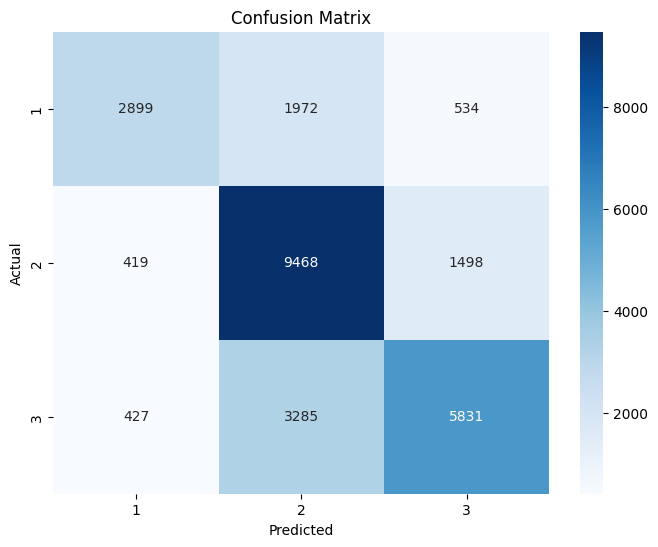

In [65]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

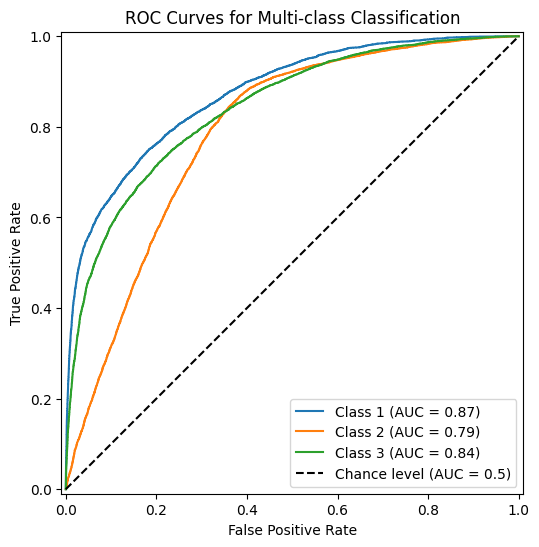

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(gb_clf.classes_):
    y_score = gb_clf.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

#### Tuned

In [66]:
y_test_pred = gb_clf_best_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.77      0.54      0.64      5405
           2       0.65      0.83      0.72     11385
           3       0.74      0.62      0.67      9543

    accuracy                           0.69     26333
   macro avg       0.72      0.66      0.68     26333
weighted avg       0.71      0.69      0.69     26333



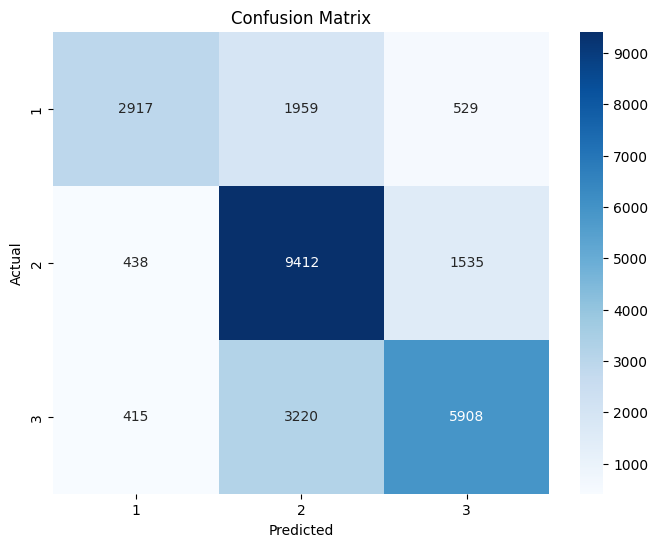

In [67]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

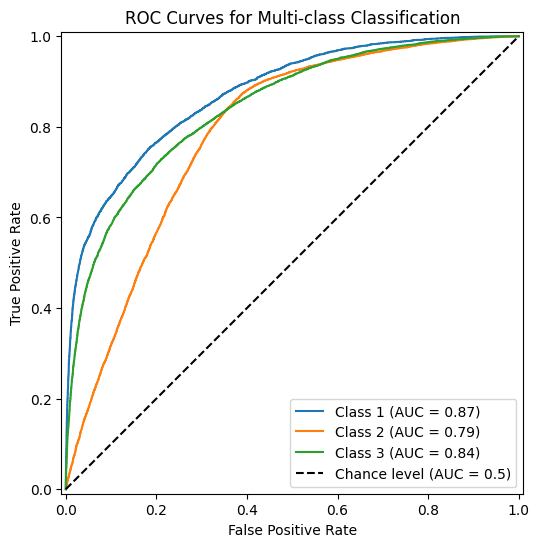

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(gb_clf_best_model.classes_):
    y_score = gb_clf_best_model.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

### 7.2.4 KNN

#### Not Tuned

In [68]:
y_test_pred = knn.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.58      0.56      0.57      5405
           2       0.62      0.70      0.66     11385
           3       0.67      0.58      0.62      9543

    accuracy                           0.63     26333
   macro avg       0.62      0.61      0.62     26333
weighted avg       0.63      0.63      0.63     26333



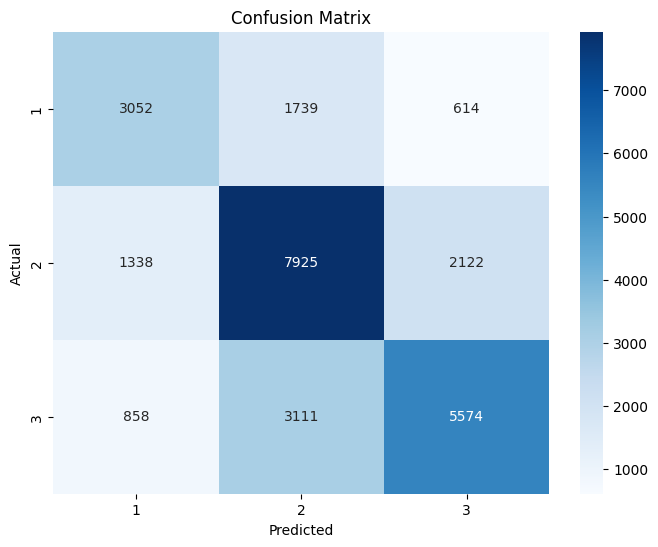

In [69]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

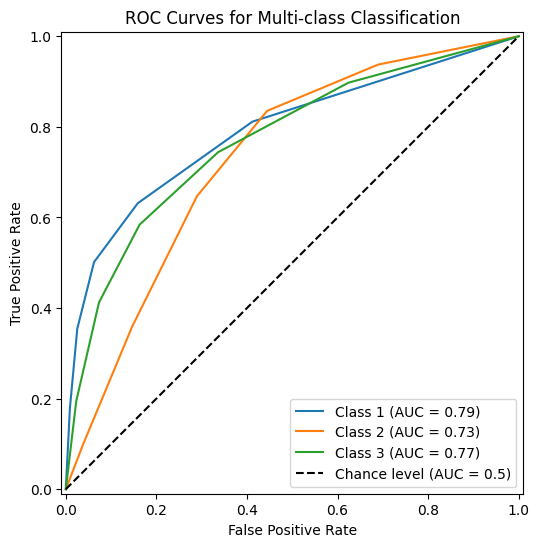

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(knn.classes_):
    y_score = knn.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()

#### Tuned

In [77]:
y_pred = knn_best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.54      0.62      5405
           2       0.64      0.82      0.72     11385
           3       0.73      0.58      0.65      9543

    accuracy                           0.68     26333
   macro avg       0.69      0.65      0.66     26333
weighted avg       0.69      0.68      0.67     26333



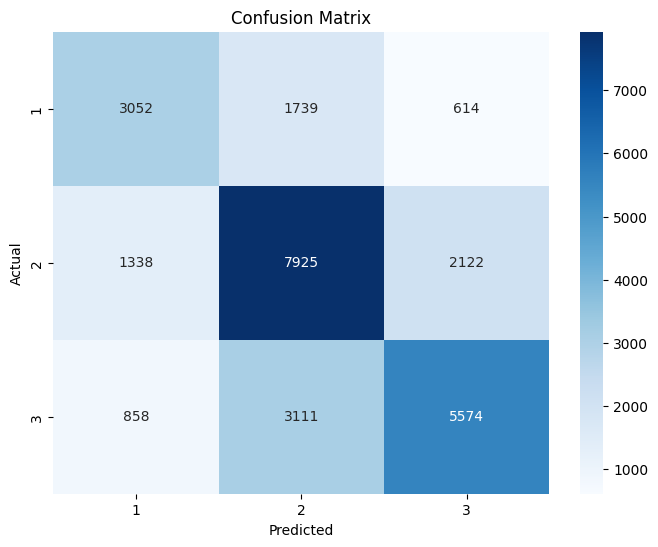

In [78]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3],
            yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

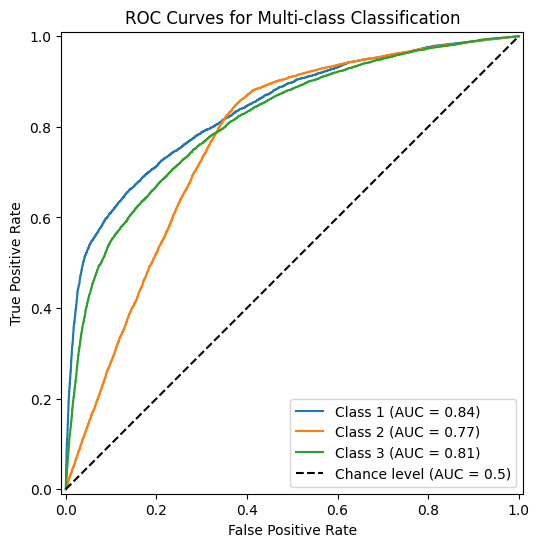

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, class_label in enumerate(knn_best_model.classes_):
    y_score = knn_best_model.predict_proba(X_test)[:, i]

    y_binary = (y_test == class_label).astype(int)

    fpr, tpr, _ = roc_curve(y_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                   estimator_name=f'Class {class_label}').plot(ax=ax)

ax.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Multi-class Classification')
ax.legend(loc='lower right')
plt.show()